MNIST-获取数据

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch

transformation = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('data/', train=True, transform=transformation, download=False)
test_dataset = datasets.MNIST('data/', train=False, transform=transformation, download=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=True)

/home/pc/anaconda3/envs/mocnf/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


先来看一下要处理的数据是什么样的。

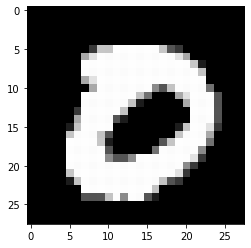

In [6]:
from matplotlib import pyplot as plt

def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image, cmap='gray')

sample_data = next(iter(train_loader))
plot_img(sample_data[0][1])

网络架构：Conv2d-MaxPool2d-RELU-Conv2d-dropout-MaxPool2d-RELU-view-FC-RELU-dropout-FC-Log_softmax

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

训练模型

/tmp/ipykernel_19524/3814534869.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


loss:0.7108553030490875,accuracy:76.73332977294922
loss:0.13087592151761054,accuracy:96.0199966430664
loss:0.3166411794702212,accuracy:90.66666412353516
loss:0.09077916086018085,accuracy:97.19999694824219
loss:0.2603184778581063,accuracy:92.42666625976562
loss:0.07605187752991915,accuracy:97.66999816894531
loss:0.21999452508936326,accuracy:93.51166534423828
loss:0.06616937659205868,accuracy:97.94000244140625
loss:0.20360338231101632,accuracy:94.05000305175781
loss:0.05641131785046309,accuracy:98.19000244140625
loss:0.19232547207425038,accuracy:94.36333465576172
loss:0.05294570525120944,accuracy:98.31999969482422
loss:0.177089246109128,accuracy:94.82166290283203
loss:0.05062598988581449,accuracy:98.37000274658203
loss:0.17134511339987318,accuracy:95.086669921875
loss:0.04748672368163243,accuracy:98.41999816894531
loss:0.15686945717831452,accuracy:95.3550033569336
loss:0.043827999701397495,accuracy:98.54000091552734
loss:0.15164154340798655,accuracy:95.61833190917969
loss:0.0420712557069

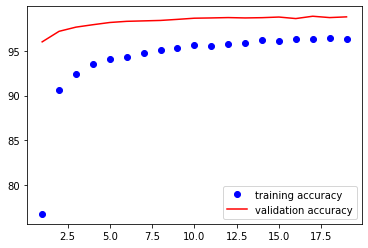

In [20]:
from torch.autograd import Variable
import torch.optim as optim

model = Net()
if torch.cuda.is_available():
    model.cuda()
#model.cuda()要写在optimizer之前，因为在CPU和GPU上的模型参数不一样
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile = True
    running_loss = 0.0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        running_loss += F.nll_loss(output, target, size_average=False).item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct / len(data_loader.dataset)
    print('loss:{0},accuracy:{1}'.format(loss, accuracy))
    return loss, accuracy

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 20):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'bo', label = 'training accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label = 'validation accuracy')
plt.legend()